In [1]:
from lstm_module import LSTM_SS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-2.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])
#df.index.freq='MS'

In [3]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [4]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 05:00:00,23.00,89.00,15.76,19.25,28.34,39.31
2019-09-13 06:00:00,23.14,87.31,16.27,19.25,32.36,44.94
2019-09-13 07:00:00,24.23,83.01,16.25,19.26,58.58,82.12
2019-09-13 08:00:00,25.45,76.43,16.15,19.26,43.30,60.28
2019-09-13 09:00:00,27.85,66.55,16.39,19.25,48.00,66.76
...,...,...,...,...,...,...
2020-01-11 13:00:00,18.88,48.85,41.00,1.38,89.39,124.32
2020-01-11 14:00:00,19.03,47.54,41.00,1.43,77.89,108.28
2020-01-11 15:00:00,19.00,46.44,41.00,1.47,64.70,89.90


In [5]:
pm = one_hr_sample[['PM2.5']].copy()

In [6]:
pm

,PM2.5
date,
2019-09-13 05:00:00,28.34
2019-09-13 06:00:00,32.36
2019-09-13 07:00:00,58.58
2019-09-13 08:00:00,43.30
2019-09-13 09:00:00,48.00
...,...
2020-01-11 13:00:00,89.39
2020-01-11 14:00:00,77.89
2020-01-11 15:00:00,64.70


In [7]:
df = pm.copy()

In [8]:
df.isna().sum()

PM2.5    1142
dtype: int64

In [9]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

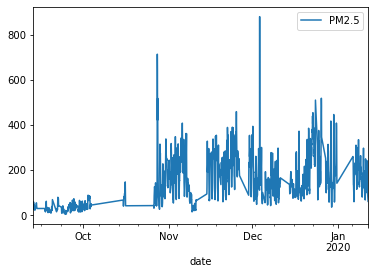

In [10]:
df.plot()

In [11]:
len(df)

2893

In [12]:
train = df.iloc[:2869]
test = df.iloc[2869:]

scaler = MinMaxScaler()

In [13]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

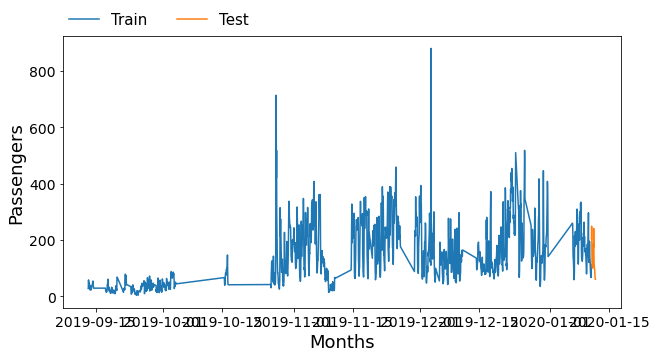

In [14]:
plt.figure(figsize=(10, 5))

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')

plt.xlabel('Months', fontsize=18)
plt.ylabel('Passengers', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})

plt.show()


In [15]:
n_input = 24
n_features = 1

def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-n_input):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input])
    return np.array(X), np.array(y)

X, y = generate_data(scaled_train, n_input)

# Original LSTM

In [16]:
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X, y, epochs=50, verbose=0)

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.13810894], dtype=float32),
 array([0.14404738], dtype=float32),
 array([0.14451532], dtype=float32),
 array([0.14708191], dtype=float32),
 array([0.14836966], dtype=float32),
 array([0.14615086], dtype=float32),
 array([0.14044298], dtype=float32),
 array([0.13237013], dtype=float32),
 array([0.12340589], dtype=float32),
 array([0.11657493], dtype=float32),
 array([0.11331433], dtype=float32),
 array([0.11399436], dtype=float32),
 array([0.11774871], dtype=float32),
 array([0.12180553], dtype=float32),
 array([0.12262592], dtype=float32),
 array([0.11878286], dtype=float32),
 array([0.1111514], dtype=float32),
 array([0.10113178], dtype=float32),
 array([0.09076098], dtype=float32),
 array([0.08148362], dtype=float32),
 array([0.07436654], dtype=float32),
 array([0.06987072], dtype=float32),
 array([0.06828785], dtype=float32),
 array([0.06974489], dtype=float32)]

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

test['original_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

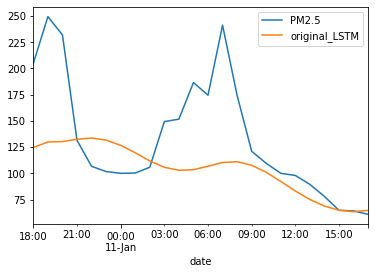

In [20]:
test.plot()

In [21]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['original_LSTM']))
print(rmse)

54.57279211878325


In [22]:
test

,PM2.5,original_LSTM
date,,
2020-01-10 18:00:00,204.77,124.592485
2020-01-10 19:00:00,249.29,129.797528
2020-01-10 20:00:00,231.89,130.207679
2020-01-10 21:00:00,131.43,132.457295
2020-01-10 22:00:00,106.64,133.586003
2020-01-10 23:00:00,101.65,131.641226
2020-01-11 00:00:00,99.95,126.638274
2020-01-11 01:00:00,100.23,119.562418
2020-01-11 02:00:00,105.74,111.705261


# SELF_MADE_LSTM

In [23]:
self_model = LSTM_SS(1, 1, 200, n_input, 0.01)

In [24]:
self_model.fit(50, X, y, verbose=False)

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = self_model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.07399956]),
 array([0.10784375]),
 array([0.1050097]),
 array([0.10043282]),
 array([0.11616077]),
 array([0.19847141]),
 array([0.0701319]),
 array([0.08136047]),
 array([0.09663933]),
 array([0.09297305]),
 array([0.10888925]),
 array([0.13251731]),
 array([0.11647196]),
 array([0.09161673]),
 array([0.10338498]),
 array([0.08857289]),
 array([0.08797355]),
 array([0.07579334]),
 array([0.07416769]),
 array([0.07192425]),
 array([0.05922851]),
 array([0.10912709]),
 array([0.06067051]),
 array([0.0896217])]

In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

test['SELF_MADE_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

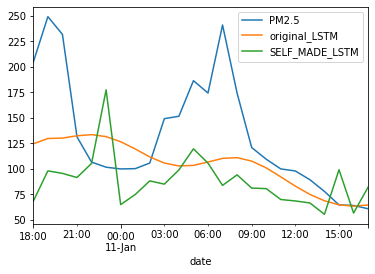

In [27]:
test.plot()

In [28]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['SELF_MADE_LSTM']))
print(rmse)

71.7866353753504


In [29]:
test

,PM2.5,original_LSTM,SELF_MADE_LSTM
date,,,
2020-01-10 18:00:00,204.77,124.592485,68.400611
2020-01-10 19:00:00,249.29,129.797528,98.065048
2020-01-10 20:00:00,231.89,130.207679,95.581004
2020-01-10 21:00:00,131.43,132.457295,91.569364
2020-01-10 22:00:00,106.64,133.586003,105.354914
2020-01-10 23:00:00,101.65,131.641226,177.500192
2020-01-11 00:00:00,99.95,126.638274,65.010613
2020-01-11 01:00:00,100.23,119.562418,74.852449
2020-01-11 02:00:00,105.74,111.705261,88.244373
